In [232]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [233]:
train_df = pd.read_csv("./jinnan_round1_train_20181227.csv", encoding = 'gb18030')
test_df = pd.read_csv("./jinnan_round1_testA_20181227.csv", encoding = 'gb18030')

In [234]:
train_df['A21'] = train_df['A21'].fillna(train_df['A21'].median())
train_df['B1'] = train_df['B1'].fillna(train_df['B1'].median())
train_df['B8'] = train_df['B8'].fillna(train_df['B8'].median())
train_df['B12'] = train_df['B12'].fillna(train_df['B12'].median())
def processError(df):
    if df == '1900/3/10 0:00':
        return 70
    return df
train_df['A25'] = train_df['A25'].apply(lambda x: processError(x))
train_df['A25'] = train_df['A25'].fillna(train_df['A25'].median())
train_df['A23'] = train_df['A23'].fillna(train_df['A23'].median())
train_df['B2'] = train_df['B2'].fillna(train_df['B2'].median())
train_df['B3'] = train_df['B3'].fillna(train_df['B3'].median())
train_df['B13'] = train_df['B13'].fillna(train_df['B13'].median())
test_df['A25'] = test_df['A25'].fillna(train_df['A25'].median())
test_df['A27'] = test_df['A27'].fillna(train_df['A27'].median())
test_df['B1'] = test_df['B1'].fillna(train_df['B1'].median())

In [235]:
views = []
for col in train_df.columns:
    views.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
26,A26,88,0.143266,18.982808,object
24,A24,91,0.071633,18.481375,object
33,B5,60,0.071633,17.550143,object
0,sample id,1396,0.000000,0.071633,object


In [236]:
views = []
for col in test_df.columns:
    views.append((col, test_df[col].nunique(), test_df[col].isnull().sum() * 100 / test_df.shape[0], test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, test_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
20,A20,52,0.666667,20.000000,object
0,sample id,150,0.000000,0.666667,object
32,B4,51,0.000000,20.666667,object
26,A26,41,0.000000,21.333333,object


In [237]:
for df in [train_df, test_df]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

features = list(train_df.columns)
for col in train_df.columns:
    rate = train_df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        features.remove(col)
train_df = train_df[features]
features.remove('score')
test_df = test_df[features]

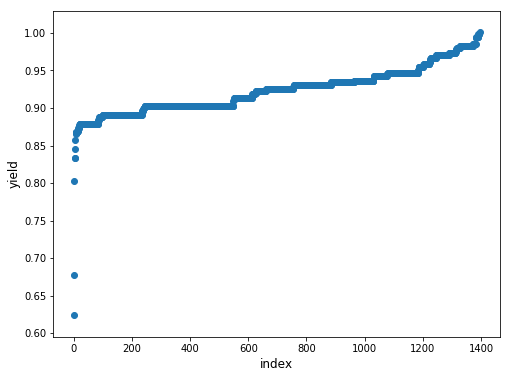

In [238]:
target_col = 'score'
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

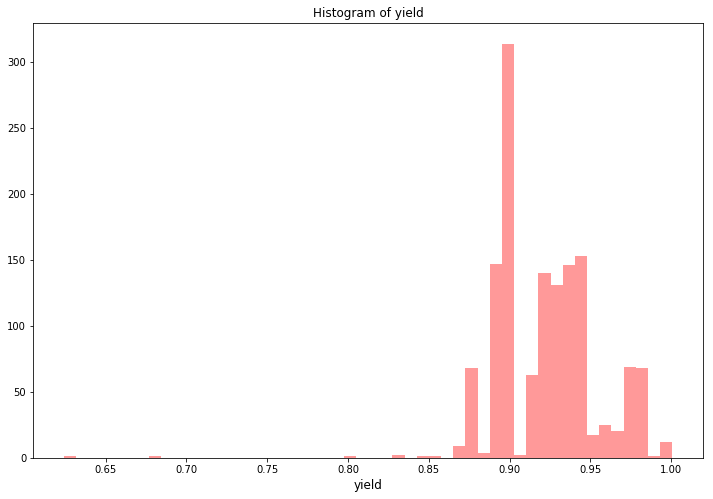

In [239]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [240]:
train_df = train_df[train_df[target_col]>0.87]

In [241]:
def TimeToInt(str, previous = 0):
    now = 0
    try:
        time = str.split(":")
        now = int(time[0]) * 60 + int(time[1])
        if now < previous:
            now += 24 * 60
    except:
        now = -1
    return now / 60

def getInt(str):
    val = str.split(":")
    return int(val[0]) * 60 + int(val[1])

def TimeToDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1
    try:
        duration = int(eh)*60+int(em)-int(sm)-int(sh)*60
        if duration < 0:
            duration += 24 * 60
        return duration
    except:
        return 0

def Between(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    duration = 0
    try:
        duration = t1 - t2
        if duration < 0:
            duration += 24.0
    except:
        duration = -1
    return duration

In [242]:
for df in [train_df, test_df]:
    df['A5'] = df['A5'].apply(lambda x: TimeToInt(x))
    df['A7'] = df['A7'].apply(lambda x: TimeToInt(x))
    df['A9'] = df.apply(lambda x: TimeToInt(x.A9, x.A5), axis = 1)
    df['A11'] = df.apply(lambda x: TimeToInt(x.A11, x.A9), axis = 1)
    df['A14'] = df.apply(lambda x: TimeToInt(x.A14, x.A11), axis = 1)
    df['A16'] = df.apply(lambda x: TimeToInt(x.A16, x.A14), axis = 1)
    df['A24'] = df.apply(lambda x: TimeToInt(x.A24, x.A16), axis = 1)
    df['A26'] = df.apply(lambda x: TimeToInt(x.A26, x.A24), axis = 1)
    df['B5'] = df.apply(lambda x: TimeToInt(x.B5, x.A26), axis = 1)
    df['B7'] = df.apply(lambda x: TimeToInt(x.B7, x.B5), axis = 1)
#for df in [train_df, test_df]:
#    for col in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
#        df[col] = df.apply(lambda df: timeTranSecond(df[col]), axis=1)

In [243]:
for df in [train_df, test_df]:
    df['A7A5'] = df.apply(lambda x: Between(x['A7'], x['A5']), axis=1)
    df['A9A5'] = df.apply(lambda x: Between(x['A9'], x['A5']), axis=1)
    df['A11A9'] = df.apply(lambda x: Between(x['A11'], x['A9']), axis=1)
    df['A14A11'] = df.apply(lambda x: Between(x['A14'], x['A11']), axis=1)
    df['A16A14'] = df.apply(lambda x: Between(x['A16'], x['A14']), axis=1)
    df['A24A16'] = df.apply(lambda x: Between(x['A24'], x['A16']), axis=1)
    df['A26A24'] = df.apply(lambda x: Between(x['A26'], x['A24']), axis=1)
    df['B5A26'] = df.apply(lambda x: Between(x['B5'], x['A26']), axis=1)
    df['B7B5'] = df.apply(lambda x: Between(x['B7'], x['B5']), axis=1)

In [244]:
df.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14
0,sample_1656,6.0,29,-1.000000,NaN,2.000000,101,7.0,103.0,3.000000,105.0,8.0,106.0,200,11:00-12:00,9,4.0,80.0,9.0,73.0,13:00-14:00,320.0,14:00-15:00,6.000000,79,11.000000,45,17:00-18:30,18:30-20:00,20:00-21:00,1200,400
1,sample_1548,12.5,39,0.333333,80.0,1.833333,100,13.5,102.0,2.833333,103.0,14.5,102.0,300,20:00-20:30,9,6.5,76.0,15.0,75.0,6:00-6:30,350.0,6:30-7:50,16.833333,65,17.166667,45,12:00-13:00,14:00-15:30,NaN,800,385
2,sample_769,6.0,80,-1.000000,NaN,2.000000,102,7.0,104.0,3.000000,104.0,8.0,105.0,200,11:00-12:00,9,4.0,80.0,9.0,73.0,13:00-14:00,320.0,14:00-15:00,6.000000,80,11.000000,45,17:00-20:00,NaN,NaN,1200,440
3,sample_1881,22.0,29,-1.000000,NaN,2.000000,102,23.0,103.0,3.000000,104.0,0.0,105.0,200,3:00-4:00,9,4.0,78.0,1.0,73.0,5:00-6:00,320.0,6:00-7:00,6.000000,80,3.000000,45,9:00-10:30,10:30-12:00,12:00-13:00,1200,400
4,sample_1807,22.0,30,-1.000000,NaN,2.000000,101,23.0,104.0,3.000000,106.0,0.0,107.0,200,3:00-4:00,9,4.0,79.0,1.0,72.0,5:00-6:00,320.0,6:00-7:00,6.000000,79,3.000000,45,9:00-10:30,10:30-12:00,12:00-13:00,1200,400


In [245]:
for df in [train_df, test_df]:
    for col in ['A20', 'A28', 'B4', 'B9', 'B10', 'B11']:
        df[col] = df.apply(lambda df: TimeToDuration(df[col]), axis=1)

In [246]:
train_df.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,score
0,sample_1528,13.5,38.0,-1.0,NaN,2.0,100,14.5,102,3.0,103.0,15.5,104.0,300,30,9.0,6.5,75,16.0,70,30,350.0,60,16.0,65,19.5,45.0,90,90,0,800.0,400,0.879
1,sample_1698,14.0,29.0,-1.0,NaN,2.0,101,15.0,103,3.0,104.0,16.0,105.0,200,60,9.0,4.0,80,17.0,73,60,320.0,60,6.0,80,0.0,45.0,90,90,60,1200.0,400,0.902
2,sample_639,14.0,29.0,-1.0,NaN,2.0,102,15.0,103,3.0,104.0,16.0,105.0,200,30,9.0,4.0,79,17.0,73,60,320.0,60,6.0,80,19.0,45.0,90,90,60,1200.0,400,0.936
3,sample_483,1.5,38.0,-1.0,NaN,1.5,100,2.5,102,2.5,103.0,3.5,104.0,200,30,10.0,4.0,70,4.0,78,60,290.0,60,11.5,65,6.5,45.0,90,90,0,800.0,400,0.902
4,sample_617,22.0,29.0,-1.0,NaN,2.0,101,23.0,103,3.0,104.0,0.0,105.0,200,60,9.0,4.0,80,1.0,73,60,320.0,60,6.0,80,3.0,45.0,90,90,60,1200.0,420,0.983


In [247]:
target = train_df['score']
del train_df['score']
data = pd.concat([train_df,test_df],axis=0,ignore_index=True)
data = data.fillna(-1)

cate_columns = [f for f in data.columns if f != 'sample id']

#label encoder
for f in cate_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train_df.shape[0]]
test  = data[train_df.shape[0]:]

In [248]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
train.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,target,intTarget_0.0,intTarget_1.0,intTarget_2.0,intTarget_3.0,intTarget_4.0
0,sample_1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.879,1,0,0,0,0
1,sample_1698,1,1,0,0,0,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,0,0,0,1,1,0,0.902,0,1,0,0,0
2,sample_639,1,1,0,0,0,2,1,1,0,1,1,1,1,0,0,1,2,1,1,1,1,0,1,1,2,0,0,0,1,1,0,0.936,0,0,1,0,0
3,sample_483,2,0,0,0,1,0,2,0,1,0,2,0,1,0,1,1,3,2,2,1,2,0,2,0,3,0,0,0,0,0,0,0.902,0,1,0,0,0
4,sample_617,3,1,0,0,0,1,3,1,0,1,3,1,1,1,0,1,1,3,1,1,1,0,1,1,4,0,0,0,1,1,1,0.983,0,0,0,0,1


In [249]:
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_features = []
for f1 in cate_columns:
    for f2 in li:
        col_name = f1+"_"+f2+'_mean'
        mean_features.append(col_name)
        order_label = train.groupby([f1])[f2].mean()
        for df in [train, test]:
            df[col_name] = df[f1].map(order_label)

for f1 in cate_columns:
    for f2 in li:
        col_name = f1+"_"+f2+'_b14_mean'
        order_label = train.groupby([f1])[f2].mean()
        for df in [train, test]:
            df[col_name] = df['B14'].map(order_label) 
            
train.drop(li, axis=1, inplace=True)

In [250]:
train.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,target,A5_intTarget_0.0_mean,A5_intTarget_1.0_mean,A5_intTarget_2.0_mean,A5_intTarget_3.0_mean,A5_intTarget_4.0_mean,A6_intTarget_0.0_mean,A6_intTarget_1.0_mean,A6_intTarget_2.0_mean,A6_intTarget_3.0_mean,A6_intTarget_4.0_mean,A7_intTarget_0.0_mean,A7_intTarget_1.0_mean,A7_intTarget_2.0_mean,A7_intTarget_3.0_mean,A7_intTarget_4.0_mean,A8_intTarget_0.0_mean,A8_intTarget_1.0_mean,A8_intTarget_2.0_mean,A8_intTarget_3.0_mean,A8_intTarget_4.0_mean,A9_intTarget_0.0_mean,A9_intTarget_1.0_mean,A9_intTarget_2.0_mean,A9_intTarget_3.0_mean,A9_intTarget_4.0_mean,A10_intTarget_0.0_mean,A10_intTarget_1.0_mean,A10_intTarget_2.0_mean,A10_intTarget_3.0_mean,A10_intTarget_4.0_mean,A11_intTarget_0.0_mean,A11_intTarget_1.0_mean,A11_intTarget_2.0_mean,A11_intTarget_3.0_mean,A11_intTarget_4.0_mean,A12_intTarget_0.0_mean,A12_intTarget_1.0_mean,A12_intTarget_2.0_mean,A12_intTarget_3.0_mean,A12_intTarget_4.0_mean,A14_intTarget_0.0_mean,A14_intTarget_1.0_mean,A14_intTarget_2.0_mean,A14_intTarget_3.0_mean,A14_intTarget_4.0_mean,A15_intTarget_0.0_mean,A15_intTarget_1.0_mean,A15_intTarget_2.0_mean,A15_intTarget_3.0_mean,A15_intTarget_4.0_mean,A16_intTarget_0.0_mean,A16_intTarget_1.0_mean,A16_intTarget_2.0_mean,A16_intTarget_3.0_mean,A16_intTarget_4.0_mean,A17_intTarget_0.0_mean,A17_intTarget_1.0_mean,A17_intTarget_2.0_mean,A17_intTarget_3.0_mean,A17_intTarget_4.0_mean,A19_intTarget_0.0_mean,A19_intTarget_1.0_mean,A19_intTarget_2.0_mean,A19_intTarget_3.0_mean,A19_intTarget_4.0_mean,A20_intTarget_0.0_mean,A20_intTarget_1.0_mean,A20_intTarget_2.0_mean,A20_intTarget_3.0_mean,A20_intTarget_4.0_mean,A22_intTarget_0.0_mean,A22_intTarget_1.0_mean,A22_intTarget_2.0_mean,A22_intTarget_3.0_mean,A22_intTarget_4.0_mean,A24_intTarget_0.0_mean,A24_intTarget_1.0_mean,A24_intTarget_2.0_mean,A24_intTarget_3.0_mean,A24_intTarget_4.0_mean,A25_intTarget_0.0_mean,A25_intTarget_1.0_mean,A25_intTarget_2.0_mean,A25_intTarget_3.0_mean,A25_intTarget_4.0_mean,A26_intTarget_0.0_mean,A26_intTarget_1.0_mean,A26_intTarget_2.0_mean,A26_intTarget_3.0_mean,A26_intTarget_4.0_mean,A27_intTarget_0.0_mean,A27_intTarget_1.0_mean,A27_intTarget_2.0_mean,A27_intTarget_3.0_mean,A27_intTarget_4.0_mean,A28_intTarget_0.0_mean,A28_intTarget_1.0_mean,A28_intTarget_2.0_mean,A28_intTarget_3.0_mean,A28_intTarget_4.0_mean,B1_intTarget_0.0_mean,B1_intTarget_1.0_mean,B1_intTarget_2.0_mean,B1_intTarget_3.0_mean,B1_intTarget_4.0_mean,B4_intTarget_0.0_mean,B4_intTarget_1.0_mean,B4_intTarget_2.0_mean,B4_intTarget_3.0_mean,B4_intTarget_4.0_mean,B5_intTarget_0.0_mean,B5_intTarget_1.0_mean,B5_intTarget_2.0_mean,B5_intTarget_3.0_mean,B5_intTarget_4.0_mean,B6_intTarget_0.0_mean,B6_intTarget_1.0_mean,B6_intTarget_2.0_mean,B6_intTarget_3.0_mean,B6_intTarget_4.0_mean,B7_intTarget_0.0_mean,B7_intTarget_1.0_mean,B7_intTarget_2.0_mean,B7_intTarget_3.0_mean,B7_intTarget_4.0_mean,B8_intTarget_0.0_mean,B8_intTarget_1.0_mean,B8_intTarget_2.0_mean,B8_intTarget_3.0_mean,B8_intTarget_4.0_mean,B9_intTarget_0.0_mean,B9_intTarget_1.0_mean,B9_intTarget_2.0_mean,B9_intTarget_3.0_mean,B9_intTarget_4.0_mean,B10_intTarget_0.0_mean,B10_intTarget_1.0_mean,B10_intTarget_2.0_mean,B10_intTarget_3.0_mean,B10_intTarget_4.0_mean,B11_intTarget_0.0_mean,B11_intTarget_1.0_mean,B11_intTarget_2.0_mean,B11_intTarget_3.0_mean,B11_intTarget_4.0_mean,B12_intTarget_0.0_mean,B12_intTarget_1.0_mean,B12_intTarget_2.0_mean,B12_intTarget_3.0_mean,B12_intTarget_4.0_mean,B14_intTarget_0.0_mean,B14_intTarget_1.0_mean,B14_intTarget_2.0_mean,B14_intTarget_3.0_mean,B14_intTarget_4.0_mean,A5_intTarget_0.0_b14_mean,A5_intTarget_1.0_b14_mean,A5_intTarget_2.0_b14_mean,A5_intTarget_3.0_b14_mean,A5_intTarget_4.0_b14_mean,A6_intTarget_0.0_b14_mean,A6_intTarget_1.0_b14_mean,A6_intTarget_2.0_b14_mean,A6_intTarget_3.0_b14_mean,A6_intTarget_4.0_b14_mean,A7_intTarget_0.0_b14_mean,A7_intTarget_1.0_b14_mean,A7_intTarget_2.0_b14_mean,A7_intTarget_3.0_b14_mean,A

In [251]:
train.drop(['sample id','target'], axis=1, inplace=True)
test = test[train.columns]
X_train = train.values
y_train = target.values
X_test = test.values

In [252]:
y_train = target.values

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

# 五折交叉验证
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    clf = lgb.train(param, 
                    trn_data, 
                    num_boost_round=10000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {}".format(mean_squared_error(oof_lgb, target)))


fold n°1
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.00021294	valid_1's l2: 0.000240191
[400]	training's l2: 0.000155399	valid_1's l2: 0.000192669
[600]	training's l2: 0.000134663	valid_1's l2: 0.000182024
[800]	training's l2: 0.000123742	valid_1's l2: 0.000178152
[1000]	training's l2: 0.000116813	valid_1's l2: 0.00017639
[1200]	training's l2: 0.000111897	valid_1's l2: 0.000175708
[1400]	training's l2: 0.000108283	valid_1's l2: 0.000175204
[1600]	training's l2: 0.000105251	valid_1's l2: 0.000174828
[1800]	training's l2: 0.000102946	valid_1's l2: 0.000174787
[2000]	training's l2: 0.000101267	valid_1's l2: 0.000174691
Early stopping, best iteration is:
[1954]	training's l2: 0.000101369	valid_1's l2: 0.000174679
fold n°2
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.000210365	valid_1's l2: 0.000252947
[400]	training's l2: 0.000151936	valid_1's l2: 0.000217767
[600]	training's l2: 0.000130746	valid_1's l2: 0.

In [253]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=200, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.42382
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.156634	valid_data-rmse:0.157323
[400]	train-rmse:0.059486	valid_data-rmse:0.06006
[600]	train-rmse:0.02485	valid_data-rmse:0.026124
[800]	train-rmse:0.01298	valid_data-rmse:0.015962
[1000]	train-rmse:0.00923	valid_data-rmse:0.013523
[1200]	train-rmse:0.007975	valid_data-rmse:0.013
[1400]	train-rmse:0.007396	valid_data-rmse:0.012892
[1600]	train-rmse:0.007013	valid_data-rmse:0.012905
Stopping. Best iteration:
[1449]	train-rmse:0.007285	valid_data-rmse:0.012876

fold n°2
[0]	train-rmse:0.424042	valid_data-rmse:0.419361
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.157029	valid_data-rmse:0.154303
[400]	train-rmse:0.059607	valid_data-r

In [254]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {}".format(mean_squared_error(target.values, oof_stack)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.00017793114427674145


In [255]:
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("submission.csv", index=False, header=None)